https://docs.pymc.io/notebooks/GP-SparseApprox.html

In [5]:
import pymc3 as pm
import theano
import theano.tensor as tt
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

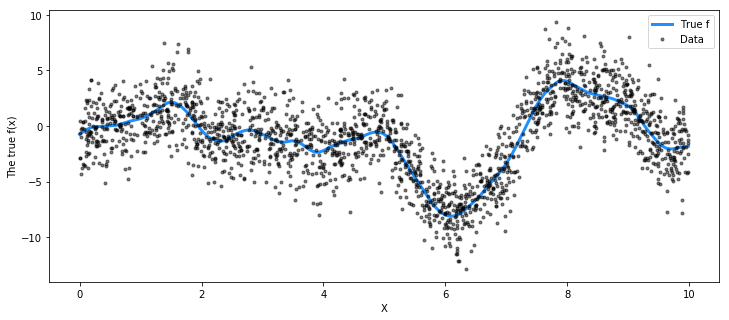

In [8]:
# set the seed
np.random.seed(1)

n = 2000 # The number of data points
X = 10*np.sort(np.random.rand(n))[:,None]

# Define the true covariance function and its parameters
l_true = 1.0
eta_true = 3.0
cov_func = eta_true**2 * pm.gp.cov.Matern52(1, l_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one 
# sample from a multivariate normal
# Note that we have to call `eval()` 
# because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(
    mean_func(X).eval(),cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus 
# a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
sigma_true = 2.0
y = f_true + sigma_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("The true f(x)"); plt.legend();

# Initializing the inducing points with K-means

We use the NUTS sampler and the FITC approximation.

In [9]:

with pm.Model() as model:
    l = pm.Gamma("l", alpha=2, beta=1)
    eta = pm.HalfCauchy("eta", beta=5)

    cov = eta**2 * pm.gp.cov.Matern52(1, l)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")

    # initialize 20 inducing points with K-means
    # gp.util
    Xu = pm.gp.util.kmeans_inducing_points(20, X)

    sigma = pm.HalfCauchy("sigma", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu, y=y, sigma=sigma)

    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/thu/anaconda2/lib/python2.7/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 1500/1500 [00:58<00:00, 25.85it/s]


In [10]:
X_new = np.linspace(-1, 11, 200)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just 
# replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_ppc(trace, vars=[f_pred], samples=1000)

100%|██████████| 1000/1000 [00:28<00:00, 34.85it/s]


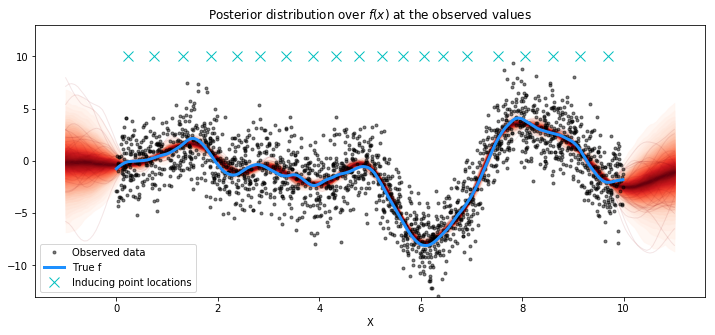

In [11]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(Xu, 10*np.ones(Xu.shape[0]), "cx", 
         ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X"); plt.ylim([-13,13]);
plt.title("Posterior distribution over 
          $f(x)$ at the observed values "); plt.legend();

## Optimizing inducing point locations as part of the model

For demonstration purposes, we set approx="VFE". Any inducing point initialization can be done with any approximation.

In [13]:
Xu_init = 10*np.random.rand(20)

with pm.Model() as model:
    l = pm.Gamma("l", alpha=2, beta=1)
    eta = pm.HalfCauchy("eta", beta=5)

    cov = eta**2 * pm.gp.cov.Matern52(1, l)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="VFE")

    # set flat prior for Xu
    Xu = pm.Flat("Xu", shape=20, testval=Xu_init)

    sigma = pm.HalfCauchy("sigma", beta=5)
    y_ = gp.marginal_likelihood("y", 
                                X=X, Xu=Xu[:, None], y=y, sigma=sigma)

    mp = pm.find_MAP()

logp = -4,303.7, ||grad|| = 0.10775: 100%|██████████| 76/76 [00:00<00:00, 161.83it/s]  


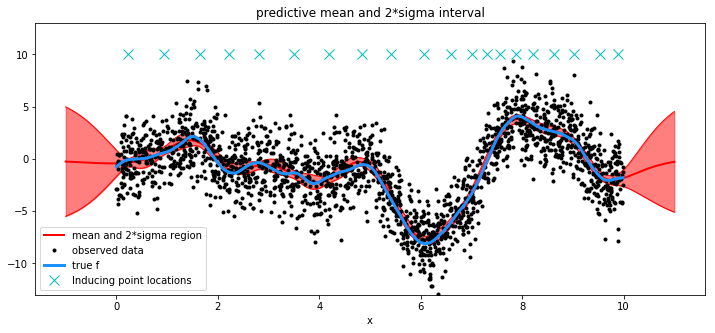

In [15]:
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2*sigma intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2*sigma region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1);
plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd,
                 mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f");
Xu = mp["Xu"]
plt.plot(Xu, 10*np.ones(Xu.shape[0]), "cx", 
         ms=10, label="Inducing point locations")

plt.xlabel("x"); plt.ylim([-13,13]);
plt.title("predictive mean and 2*sigma interval"); plt.legend();